In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings

np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4

Task: To predict whether the user likes the mobile phone or not. <br>
Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.

<b>Missing values:</b><br>
'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447)
'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467),
'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473),
'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456),
'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

<b>Very low variance:</b><br>
'Architecture'(most entries are 64-bit),'Audio Jack','GPS','Loudspeaker','Network','Network Support','Other Sensors'(28),'SIM Size', 'VoLTE'


<b>Multivalued:</b><br>
'Colours','Custom UI','Model'(1),'Other Sensors','Launch Date'

<b>Not important:</b><br>
'Bluetooth', 'Settings'(75),'Wi-Fi','Wi-Fi Features'

<b>Doubtful:</b><br>
'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing),
'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity'
    
<b>To check:</b><br>
'Display Type','Expandable Memory','FM Radio'

<b>High Correlation with other features</b><br>
'SIM Slot(s)' high correlation with SIM1
'Weight' has high high correlation with capacity , screen-to-body ratio
'Height' - screen size is also there
    
<b>Given a mobile, we can't directly get these features</b><br>
'Rating Count', 'Review Count'

<b>Keeping:</b><br>
'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',


In [255]:
# read data from file
train = pd.read_csv("/content/train.csv") 
test = pd.read_csv("/content/test.csv")

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


In [0]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

# Removing features

In [257]:
train = data_clean(train)
test = data_clean(test)
train.head()

,RAM,Image Resolution,Aspect Ratio,SIM 2,Rating Count,Operating System,Display Colour,SIM 1,SIM Slot(s),NFC,Type,Touch Screen,User Available Storage,Screen Size,Colours,Width,Display Type,Fingerprint Sensor,Height,Internal Memory,SIM Size,Graphics,Screen Resolution,Flash,Autofocus,Bezel-less display,Shooting Modes,USB Connectivity,Brand,Processor,Capacity,Other Sensors,Model,PhoneId,Thickness,Browser,Screen to Body Ratio (calculated),User Replaceable,Pixel Density,FM Radio,Review Count,Weight,Chipset,Resolution,Camera Features,Expandable Memory,Rating
0,4 GB Excellent ▾RAM compared to11 - 17 K Phone...,4000 x 3000 Pixels,19:9,4G Bands: TD-LTE 2300(band 40) / 2500(band 41)...,172274,Android v8.1 (Oreo),NaN,4G Bands:TD-LTE 2300(band 40) / 2500(band 41) ...,"Dual SIM, GSM+GSM, Dual VoLTE",NaN,Li-Polymer,"Capacitive Touchscreen, Multi-touch",Up to 52.3 GB,6.26 inches (15.9 cm),"Black, Blue, Red, Rose Gold",76.4 mm,IPS LCD,yes,157.9 mm Compare Size,64 GB Best in Class ▾Internal Memory compared ...,"SIM1: Nano, SIM2: Nano (Hybrid)",Adreno 509,1080 x 2280 pixels,Dual-color LED Flash,Phase Detection autofocus,yes,"Continuos Shooting, High Dynamic Range mode (H...","Mass storage device, USB charging, microUSB 2.0",Xiaomi,"Octa core (1.8 GHz, Quad core, Kryo 260 + 1.6 ...",4000 mAh,"Light sensor, Proximity sensor, Accelerometer,...",Redmi Note 6 Pro,0,8.2 mm Very Good ▾Thickness compared to11 - 17...,NaN,80.68 %,No,403 ppi Best in Class ▾Pixel Density compared ...,NaN,17138,182 grams Below Average ▾Weight compared to11 ...,Qualcomm Snapdragon 636,20 MP + 2 MP Dual Front Cameras Best in Class ...,"Digital Zoom, Auto Flash, Face detection, Touc...",Up to 256 GB,4.5
1,3 GB Excellent ▾RAM compared to8 - 12 K Phones...,4128 x 3096 Pixels,19:9,4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,339447,Android v8.1 (Oreo),NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,"Dual SIM, GSM+GSM, Dual VoLTE",No,Li-ion,"Capacitive Touchscreen, Multi-touch",Up to 23.2 GB,6.2 inches (15.75 cm),"Diamond Black, Diamond Blue, Diamond Red",75.6 mm,IPS LCD,yes,156.2 mm Compare Size,32 GB Excellent ▾Internal Memory compared to8 ...,"SIM1: Nano, SIM2: Nano",Adreno 506,720 x 1520 pixels,LED Flash,Phase Detection autofocus,yes,"Continuos Shooting, High Dynamic Range mode (HDR)","Mass storage device, USB charging, microUSB 2.0",Realme,"Octa core, 1.8 GHz, Cortex A53 Average ▾Proces...",4230 mAh,"Light sensor, Proximity sensor, Accelerometer,...",2,1,8.2 mm Very Good ▾Thickness compared to8 - 12 ...,NaN,80.85 %,No,271 ppi Good ▾Pixel Density compared to8 - 12 ...,NaN,38252,168 grams Average ▾Weight compared to8 - 12 K ...,Qualcomm Snapdragon 450,8 MP Front Camera Very Good ▾Front Camera comp...,"2 x Digital Zoom, Auto Flash, Face detection, ...",Up to 256 GB,4.5
2,3 GB Excellent ▾RAM compared to10 - 14 K Phone...,4128 x 3096 Pixels,19.5:9,4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,1149,Android v8.1 (Oreo),NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,"Dual SIM, GSM+GSM, Dual VoLTE",NaN,Li-ion,"Capacitive Touchscreen, Multi-touch",NaN,6.3 inches (16 cm),"Brave Blue, Fiery Gold, Ambitious Black",74 mm,IPS LCD,yes,157 mm Compare Size,32 GB Excellent ▾Internal Memory compared to10...,"SIM1: Nano, SIM2: Nano",Mali-G72 MP3,1080 x 2340 pixels,LED Flash,yes,yes,"Continuos Shooting, High Dynamic Range mode (HDR)","Mass storage device, USB charging, microUSB 2.0",Realme,"Octa core (2.1 GHz, Quad core, Cortex A73 + 2 ...",3500 mAh,"Light sensor, Proximity sensor, Accelerometer",U1,2,8 mm Very Good ▾Thickness compared to10 - 14 K...,NaN,83.68 %,No,409 ppi Best in Class ▾Pixel Density compared ...,yes,1151,168 grams Average ▾Weight compared to10 - 14 K...,MediaTek Helio P70,25 MP Front Camera Best in Class ▾Front Camera...,"2 x Digital Zoom, Auto Flash, Face detection, ...",Up to 256 GB,4.4
3,4 GB Excellent ▾RAM compared to15 - 23 K Phone...,5288 x 3968 Pixels,18.5:9,4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,6026,Android v8.0 (Oreo),NaN,4G Bands:TD-LT

removing all those data points in which more than 15 features are missing 

In [258]:
train = train[(train.isnull().sum(axis=1) <= 15)]
# You shouldn't remove data points from test set
#test = test[(test.isnull().sum(axis=1) <= 15)]
train.head()

,RAM,Image Resolution,Aspect Ratio,SIM 2,Rating Count,Operating System,Display Colour,SIM 1,SIM Slot(s),NFC,Type,Touch Screen,User Available Storage,Screen Size,Colours,Width,Display Type,Fingerprint Sensor,Height,Internal Memory,SIM Size,Graphics,Screen Resolution,Flash,Autofocus,Bezel-less display,Shooting Modes,USB Connectivity,Brand,Processor,Capacity,Other Sensors,Model,PhoneId,Thickness,Browser,Screen to Body Ratio (calculated),User Replaceable,Pixel Density,FM Radio,Review Count,Weight,Chipset,Resolution,Camera Features,Expandable Memory,Rating
0,4 GB Excellent ▾RAM compared to11 - 17 K Phone...,4000 x 3000 Pixels,19:9,4G Bands: TD-LTE 2300(band 40) / 2500(band 41)...,172274,Android v8.1 (Oreo),NaN,4G Bands:TD-LTE 2300(band 40) / 2500(band 41) ...,"Dual SIM, GSM+GSM, Dual VoLTE",NaN,Li-Polymer,"Capacitive Touchscreen, Multi-touch",Up to 52.3 GB,6.26 inches (15.9 cm),"Black, Blue, Red, Rose Gold",76.4 mm,IPS LCD,yes,157.9 mm Compare Size,64 GB Best in Class ▾Internal Memory compared ...,"SIM1: Nano, SIM2: Nano (Hybrid)",Adreno 509,1080 x 2280 pixels,Dual-color LED Flash,Phase Detection autofocus,yes,"Continuos Shooting, High Dynamic Range mode (H...","Mass storage device, USB charging, microUSB 2.0",Xiaomi,"Octa core (1.8 GHz, Quad core, Kryo 260 + 1.6 ...",4000 mAh,"Light sensor, Proximity sensor, Accelerometer,...",Redmi Note 6 Pro,0,8.2 mm Very Good ▾Thickness compared to11 - 17...,NaN,80.68 %,No,403 ppi Best in Class ▾Pixel Density compared ...,NaN,17138,182 grams Below Average ▾Weight compared to11 ...,Qualcomm Snapdragon 636,20 MP + 2 MP Dual Front Cameras Best in Class ...,"Digital Zoom, Auto Flash, Face detection, Touc...",Up to 256 GB,4.5
1,3 GB Excellent ▾RAM compared to8 - 12 K Phones...,4128 x 3096 Pixels,19:9,4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,339447,Android v8.1 (Oreo),NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,"Dual SIM, GSM+GSM, Dual VoLTE",No,Li-ion,"Capacitive Touchscreen, Multi-touch",Up to 23.2 GB,6.2 inches (15.75 cm),"Diamond Black, Diamond Blue, Diamond Red",75.6 mm,IPS LCD,yes,156.2 mm Compare Size,32 GB Excellent ▾Internal Memory compared to8 ...,"SIM1: Nano, SIM2: Nano",Adreno 506,720 x 1520 pixels,LED Flash,Phase Detection autofocus,yes,"Continuos Shooting, High Dynamic Range mode (HDR)","Mass storage device, USB charging, microUSB 2.0",Realme,"Octa core, 1.8 GHz, Cortex A53 Average ▾Proces...",4230 mAh,"Light sensor, Proximity sensor, Accelerometer,...",2,1,8.2 mm Very Good ▾Thickness compared to8 - 12 ...,NaN,80.85 %,No,271 ppi Good ▾Pixel Density compared to8 - 12 ...,NaN,38252,168 grams Average ▾Weight compared to8 - 12 K ...,Qualcomm Snapdragon 450,8 MP Front Camera Very Good ▾Front Camera comp...,"2 x Digital Zoom, Auto Flash, Face detection, ...",Up to 256 GB,4.5
2,3 GB Excellent ▾RAM compared to10 - 14 K Phone...,4128 x 3096 Pixels,19.5:9,4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,1149,Android v8.1 (Oreo),NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,"Dual SIM, GSM+GSM, Dual VoLTE",NaN,Li-ion,"Capacitive Touchscreen, Multi-touch",NaN,6.3 inches (16 cm),"Brave Blue, Fiery Gold, Ambitious Black",74 mm,IPS LCD,yes,157 mm Compare Size,32 GB Excellent ▾Internal Memory compared to10...,"SIM1: Nano, SIM2: Nano",Mali-G72 MP3,1080 x 2340 pixels,LED Flash,yes,yes,"Continuos Shooting, High Dynamic Range mode (HDR)","Mass storage device, USB charging, microUSB 2.0",Realme,"Octa core (2.1 GHz, Quad core, Cortex A73 + 2 ...",3500 mAh,"Light sensor, Proximity sensor, Accelerometer",U1,2,8 mm Very Good ▾Thickness compared to10 - 14 K...,NaN,83.68 %,No,409 ppi Best in Class ▾Pixel Density compared ...,yes,1151,168 grams Average ▾Weight compared to10 - 14 K...,MediaTek Helio P70,25 MP Front Camera Best in Class ▾Front Camera...,"2 x Digital Zoom, Auto Flash, Face detection, ...",Up to 256 GB,4.4
3,4 GB Excellent ▾RAM compared to15 - 23 K Phone...,5288 x 3968 Pixels,18.5:9,4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,6026,Android v8.0 (Oreo),NaN,4G Bands:TD-LT

In [259]:
test.head()

,RAM,Image Resolution,Aspect Ratio,SIM 2,Rating Count,Operating System,Display Colour,SIM 1,SIM Slot(s),NFC,Type,Touch Screen,User Available Storage,Screen Size,Colours,Width,Display Type,Fingerprint Sensor,Height,Internal Memory,SIM Size,Graphics,Screen Resolution,Flash,Autofocus,Bezel-less display,Shooting Modes,USB Connectivity,Brand,Processor,Capacity,Other Sensors,Model,PhoneId,Thickness,Browser,Screen to Body Ratio (calculated),User Replaceable,Pixel Density,FM Radio,Review Count,Weight,Chipset,Resolution,Camera Features,Expandable Memory
0,2 GB Very Good ▾RAM compared to6 - 8 K PhonesA...,4128 x 3096 Pixels,19:9,4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,177067,Android v8.1 (Oreo),NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,"Dual SIM, GSM+GSM, Dual VoLTE",No,Li-ion,"Capacitive Touchscreen, Multi-touch",Up to 8.67 GB,6.2 inches (15.75 cm),"Black, Blue",75.6 mm,IPS LCD,No,156.2 mm Compare Size,16 GB Very Good ▾Internal Memory compared to6 ...,"SIM1: Nano, SIM2: Nano",Adreno 506,720 x 1520 pixels,LED Flash,Phase Detection autofocus,yes,"Continuos Shooting, High Dynamic Range mode (HDR)","Mass storage device, USB charging, microUSB 2.0",Realme,"Octa core, 1.8 GHz, Cortex A53 Average ▾Proces...",4230 mAh,"Light sensor, Proximity sensor, Accelerometer,...",C1,3,8.2 mm Very Good ▾Thickness compared to6 - 8 K...,NaN,80.85 %,No,271 ppi Good ▾Pixel Density compared to6 - 8 K...,yes,20529,168 grams Average ▾Weight compared to6 - 8 K P...,Qualcomm Snapdragon 450,5 MP Front Camera Average ▾Front Camera compar...,"Digital Zoom, Auto Flash, Face detection, Touc...",Up to 256 GB
1,4 GB Excellent ▾RAM compared to12 - 18 K Phone...,4616 x 3464 Pixels,19:9,4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,50300,Android v8.1 (Oreo),NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,"Dual SIM, GSM+GSM, Dual VoLTE",No,Li-ion,"Capacitive Touchscreen, Multi-touch",NaN,6.2 inches (15.75 cm),Black,76 mm,IPS LCD,yes,156 mm Compare Size,64 GB Best in Class ▾Internal Memory compared ...,"SIM1: Nano, SIM2: Nano",Adreno 509,1080 x 2246 pixels,LED Flash,Phase Detection autofocus,yes,"Continuos Shooting, High Dynamic Range mode (HDR)","Mass storage device, USB charging",Motorola,"Octa core (1.8 GHz, Quad core, Kryo 260 + 1.6 ...",5000 mAh,"Light sensor, Proximity sensor, Accelerometer,...",One Power,11,8.9 mm Good ▾Thickness compared to12 - 18 K Ph...,NaN,81.6 %,No,402 ppi Best in Class ▾Pixel Density compared ...,yes,7883,205 grams Poor ▾Weight compared to12 - 18 K Ph...,Qualcomm Snapdragon 636,12 MP Front Camera Very Good ▾Front Camera com...,"Digital Zoom, Auto Flash, Face detection, Touc...",Up to 256 GB
2,6 GB Best in Class ▾RAM compared to16 - 24 K P...,4616 x 3464 Pixels,19.5:9,4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,15024,Android v8.1 (Oreo),NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,"Dual SIM, GSM+GSM, Dual VoLTE",No,Li-Polymer,"Capacitive Touchscreen, Multi-touch",Up to 48.6 GB,6.3 inches (16 cm),"Sunrise Red, Twilight Blue, Starry Purple",74 mm,IPS LCD,yes,156.7 mm Compare Size,64 GB Best in Class ▾Internal Memory compared ...,"SIM1: Nano, SIM2: Nano",Mali-G72 MP3,1080 x 2340 pixels,Screen flash,yes,yes,"Continuos Shooting, High Dynamic Range mode (HDR)","Mass storage device, USB charging, microUSB 2.0",OPPO,"Octa core (2 GHz, Quad core, Cortex A73 + 2 GH...",3500 mAh,"Light sensor, Proximity sensor, Accelerometer,...",F9 Pro,13,8 mm Very Good ▾Thickness compared to16 - 24 K...,NaN,83.84 %,No,409 ppi Best in Class ▾Pixel Density compared ...,yes,3113,169 grams Average ▾Weight compared to16 - 24 K...,MediaTek Helio P60,25 MP Front Camera Best in Class ▾Front Camera...,Wide Angle Selfie,Up to 256 GB
3,4 GB Excellent ▾RAM compared to13 - 19 K Phone...,4616 x 3464 Pixels,19.5:9,4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,12106,Android v8.1 (Oreo),NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,"Dual SIM, GSM+GSM, Dual VoLTE",No,Li-Polymer,"Capacitive Touchscreen, Multi-touch",NaN,6.3 inches (1

In [260]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


# Filling Missing values

In [0]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass


In [0]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_integer)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isna() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isna() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isna() == True] = "Other"


    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isna() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isna() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isna() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isna() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isna() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isna() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isna() == True] = "Other"
    
    return data

In [263]:
train = data_clean_2(train)
test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


In [264]:
train.head()

,RAM,Image Resolution,Aspect Ratio,SIM 2,Rating Count,Operating System,Display Colour,SIM 1,SIM Slot(s),NFC,Type,Touch Screen,User Available Storage,Screen Size,Colours,Width,Display Type,Fingerprint Sensor,Height,Internal Memory,SIM Size,Graphics,Screen Resolution,Flash,Autofocus,Bezel-less display,Shooting Modes,USB Connectivity,Brand,Processor,Capacity,Other Sensors,Model,PhoneId,Thickness,Browser,Screen to Body Ratio (calculated),User Replaceable,Pixel Density,FM Radio,Review Count,Weight,Chipset,Resolution,Camera Features,Expandable Memory,Rating,Num_cores,Processor_frequency,os_name,Sim1
0,4,4000 x 3000 Pixels,19:9,4G,172274,Android v8.1 (Oreo),NaN,4G Bands:TD-LTE 2300(band 40) / 2500(band 41) ...,"Dual SIM, GSM+GSM, Dual VoLTE",NaN,Li-Polymer,"Capacitive Touchscreen, Multi-touch",Up to 52.3 GB,6.26,"Black, Blue, Red, Rose Gold",76.4,IPS LCD,yes,157.9,64,"SIM1: Nano, SIM2: Nano (Hybrid)",Adreno 509,1080 x 2280 pixels,Dual-color LED Flash,Phase Detection autofocus,yes,"Continuos Shooting, High Dynamic Range mode (H...","Mass storage device, USB charging, microUSB 2.0",Xiaomi,"Octa core (1.8 GHz, Quad core, Kryo 260 + 1.6 ...",4000,"Light sensor, Proximity sensor, Accelerometer,...",Redmi Note 6 Pro,0,8.2,NaN,80.68,No,403,NaN,17138,182,Qualcomm Snapdragon 636,20,"Digital Zoom, Auto Flash, Face detection, Touc...",Up to 256 GB,4.5,Octa,1.8,Android,4G
1,3,4128 x 3096 Pixels,19:9,4G,339447,Android v8.1 (Oreo),NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,"Dual SIM, GSM+GSM, Dual VoLTE",No,Li-ion,"Capacitive Touchscreen, Multi-touch",Up to 23.2 GB,6.20,"Diamond Black, Diamond Blue, Diamond Red",75.6,IPS LCD,yes,156.2,32,"SIM1: Nano, SIM2: Nano",Adreno 506,720 x 1520 pixels,LED Flash,Phase Detection autofocus,yes,"Continuos Shooting, High Dynamic Range mode (HDR)","Mass storage device, USB charging, microUSB 2.0",Realme,"Octa core, 1.8 GHz, Cortex A53 Average ▾Proces...",4230,"Light sensor, Proximity sensor, Accelerometer,...",2,1,8.2,NaN,80.85,No,271,NaN,38252,168,Qualcomm Snapdragon 450,8,"2 x Digital Zoom, Auto Flash, Face detection, ...",Up to 256 GB,4.5,Octa,1.8,Android,4G
2,3,4128 x 3096 Pixels,19.5:9,4G,1149,Android v8.1 (Oreo),NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,"Dual SIM, GSM+GSM, Dual VoLTE",NaN,Li-ion,"Capacitive Touchscreen, Multi-touch",NaN,6.30,"Brave Blue, Fiery Gold, Ambitious Black",74.0,IPS LCD,yes,157.0,32,"SIM1: Nano, SIM2: Nano",Mali-G72 MP3,1080 x 2340 pixels,LED Flash,yes,yes,"Continuos Shooting, High Dynamic Range mode (HDR)","Mass storage device, USB charging, microUSB 2.0",Realme,"Octa core (2.1 GHz, Quad core, Cortex A73 + 2 ...",3500,"Light sensor, Proximity sensor, Accelerometer",U1,2,8.0,NaN,83.68,No,409,yes,1151,168,MediaTek Helio P70,25,"2 x Digital Zoom, Auto Flash, Face detection, ...",Up to 256 GB,4.4,Octa,2.1,Android,4G
3,4,5288 x 3968 Pixels,18.5:9,4G,6026,Android v8.0 (Oreo),NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,"Dual SIM, GSM+GSM",No,Li-ion,"Capacitive Touchscreen, Multi-touch",Up to 49.2 GB,6.00,"Black, Blue, Gold",76.8,Super AMOLED,yes,159.8,64,"SIM1: Nano, SIM2: Nano",Mali-G71 MP2,1080 x 2220 pixels,LED Flash,No,yes,"Continuos Shooting, High Dynamic Range mode (HDR)","Mass storage device, USB charging, microUSB 2.0",Samsung,"Octa core (2.2 GHz, Dual core, Cortex A73 + 1....",3300,"Light sensor, Proximity sensor, Accelerometer,...",Galaxy A7 2018,4,7.5,NaN,74.78,No,411,yes,779,169,Samsung Exynos 7 Octa 7885,24,"Digital Zoom, Auto Flash, Face detection, Touc...",Up to 512 GB,4.3,Octa,2.2,Android,4G
4,4,5160 x 3872 Pixels,19.5:9,4G,5175,Android v8.1 (Oreo),NaN,4G Bands:TD-LTE 2300(band 40) FD-LTE 1800(band...,"Dual SIM, GSM+GSM, Dual VoLTE",No,Li-Polymer,"Capacitive Touchscreen, Multi-touch",Up to 53.3 GB,6.50,"Black, Blue, Red",76.6,IPS LCD,yes,160.4,64,"SIM1: Nano, SIM2: Nano",Mali-G51 MP4,1080 x 2340 pixels,LED Flash,Phase Detection autofocus,yes,"Continuos Shooting, High Dynamic Range mode (HDR)","Mass storage device, USB charging, microUSB 2.0

Not very important feature

In [0]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [266]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])


Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [267]:
train.head()

,Num_cores,Screen to Body Ratio (calculated),Capacity,Processor_frequency,Resolution,SIM 2,Pixel Density,Height,Internal Memory,PhoneId,Rating,SIM Slot(s),Weight,os_name,Sim1,Screen Size,RAM,Brand
0,Octa,80.68,4000,1.8,20,4G,403,157.9,64,0,4.5,"Dual SIM, GSM+GSM, Dual VoLTE",182,Android,4G,6.26,4,Xiaomi
1,Octa,80.85,4230,1.8,8,4G,271,156.2,32,1,4.5,"Dual SIM, GSM+GSM, Dual VoLTE",168,Android,4G,6.20,3,Realme
2,Octa,83.68,3500,2.1,25,4G,409,157.0,32,2,4.4,"Dual SIM, GSM+GSM, Dual VoLTE",168,Android,4G,6.30,3,Realme
3,Octa,74.78,3300,2.2,24,4G,411,159.8,64,4,4.3,"Dual SIM, GSM+GSM",169,Android,4G,6.00,4,Samsung
4,Octa,84.23,3750,2.2,16,4G,396,160.4,64,5,4.4,"Dual SIM, GSM+GSM, Dual VoLTE",175,Android,4G,6.50,4,Honor


In [268]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'Num_cores', 'Screen to Body Ratio (calculated)', 'Capacity',
       'Processor_frequency', 'Resolution', 'SIM 2', 'Pixel Density', 'Height',
       'Internal Memory', 'SIM Slot(s)', 'Weight', 'os_name', 'Sim1',
       'Screen Size', 'RAM', 'Brand'],
      dtype='object')
(460, 87)
Index(['PhoneId', 'Screen to Body Ratio (calculated)', 'Capacity',
       'Processor_frequency', 'Resolution', 'Pixel Density', 'Height',
       'Internal Memory', 'Weight', 'Screen Size', 'RAM', 'Num_cores_312',
       'Num_cores_Deca', 'Num_cores_Dual', 'Num_cores_Hexa', 'Num_cores_Octa',
       'Num_cores_Other', 'Num_cores_Quad', 'Num_cores_Tru-Octa', 'SIM 2_2G',
       'SIM 2_3G', 'SIM 2_4G', 'SIM 2_Other', 'SIM Slot(s)_Dual SIM, GSM+CDMA',
       'SIM Slot(s)_Dual SIM, GSM+GSM',
       'SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE',
       'SIM Slot(s)_Single SIM, GSM', 'os_name_Android', 'os_name_Blackberry',
       'os_name_KAI', 'os_name_Nokia', 'os_name_Other', 'os_name_Tiz

In [0]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [270]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 88
Number of data points in test: 119
Number of features in test: 87


In [271]:
pd.set_option("max_columns", None)
train_new.head()

,PhoneId,Screen to Body Ratio (calculated),Capacity,Processor_frequency,Resolution,Pixel Density,Height,Internal Memory,Weight,Screen Size,RAM,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Sim1_2G,Sim1_3G,Sim1_4G,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,Rating
0,0,80.68,4000,1.8,20,403,157.9,64,182,6.26,4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4.5
1,1,80.85,4230,1.8,8,271,156.2,32,168,6.20,3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4.5
2,2,83.68,3500,2.1,25,409,157.0,32,168,6.30,3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4.4
3,4,74.78,3300,2.2,24,411,159.8,64,169,6.00,4,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4.3
4,5,84.23,3750,2.2,16,396,160.4,64,175,6.50,4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.4


In [272]:
test_new.head()

,PhoneId,Screen to Body Ratio (calculated),Capacity,Processor_frequency,Resolution,Pixel Density,Height,Internal Memory,Weight,Screen Size,RAM,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Sim1_2G,Sim1_3G,Sim1_4G,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi
0,3,80.85,4230,1.8,5,271,156.2,16,168,6.20,2,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,11,81.60,5000,1.8,12,402,156.0,64,205,6.20,4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13,83.84,3500,2.0,25,409,156.7,64,169,6.30,6,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,16,83.84,3500,2.0,16,409,156.7,64,169,6.30,4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,19,77.43,4000,1.8,20,403,158.6,64,181,5.99,4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [273]:
from sklearn.preprocessing import LabelEncoder

feature=['PhoneId','Screen to Body Ratio (calculated)','Capacity','Processor_frequency','Resolution','Pixel Density','Height','Internal Memory','Weight','Height','Internal Memory','Weight','Screen Size','RAM','Num_cores_312','Num_cores_Deca','Num_cores_Dual','Num_cores_Hexa','Num_cores_Octa','Num_cores_Other','Num_cores_Quad','Num_cores_Tru-Octa','SIM 2_2G','SIM 2_3G','SIM 2_4G','SIM 2_Other','SIM Slot(s)_Dual SIM, GSM+CDMA','Screen to Body Ratio (calculated)','SIM Slot(s)_Dual SIM, GSM+GSM','SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE','SIM Slot(s)_Single SIM, GSM','os_name_Android','os_name_Blackberry','os_name_Blackberry','os_name_KAI','os_name_Nokia','os_name_Other','os_name_Tizen','os_name_iOS',	'Sim1_2G',	'Sim1_3G',	'Sim1_4G',	'Brand_10.or','Brand_Apple',	'Brand_Asus',	'Brand_Billion'	,'Brand_Blackberry',	'Brand_Comio',	'Brand_Coolpad',	'Brand_Do',	'Brand_Gionee',	'Brand_Google',	'Brand_HTC'	,'Brand_Honor',	'Brand_Huawei',	'Brand_InFocus'	,'Brand_Infinix',	'Brand_Intex',	'Brand_Itel',	'Brand_Jivi',	'Brand_Karbonn',	'Brand_LG',	'Brand_Lava',	'Brand_LeEco',	'Brand_Lenovo',	'Brand_Lephone',	'Brand_Lyf',	'Brand_Meizu',	'Brand_Micromax',	'Brand_Mobiistar',	'Brand_Moto',	'Brand_Motorola',	'Brand_Nokia',	'Brand_Nubia',	'Brand_OPPO',	'Brand_OnePlus',	'Brand_Oppo',	'Brand_Panasonic'	,'Brand_Razer',	'Brand_Realme',	'Brand_Reliance',	'Brand_Samsung'	,'Brand_Sony',	'Brand_Spice',	'Brand_Tecno',	'Brand_Ulefone',	'Brand_VOTO',	'Brand_Vivo',	'Brand_Xiaomi',	'Brand_Xiaomi',	'Brand_Yu',	'Brand_iVooMi',	'Rating']

encoder=LabelEncoder()
encoded=train_new[feature].apply(encoder.fit_transform)
encoded.head(10)

,PhoneId,Screen to Body Ratio (calculated),Capacity,Processor_frequency,Resolution,Pixel Density,Height,Internal Memory,Weight,Height,Internal Memory,Weight,Screen Size,RAM,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,"SIM Slot(s)_Dual SIM, GSM+CDMA",Screen to Body Ratio (calculated),"SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",os_name_Android,os_name_Blackberry,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Sim1_2G,Sim1_3G,Sim1_4G,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi,Brand_Yu,Brand_iVooMi,Rating
0,0,207,72,11,7,40,129,5,60,129,5,60,32,3,0,0,0,0,1,0,0,0,0,0,1,0,0,207,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,17
1,1,210,79,11,3,15,120,4,46,120,4,46,29,2,0,0,0,0,1,0,0,0,0,0,1,0,0,210,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,17
2,2,229,64,16,9,44,125,4,46,125,4,46,34,2,0,0,0,0,1,0,0,0,0,0,1,0,0,229,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,16
3,3,153,57,18,8,45,141,5,47,141,5,47,26,3,0,0,0,0,1,0,0,0,0,0,1,0,0,153,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,15
4,4,234,70,18,6,36,144,5,53,144,5,53,38,3,0,0,0,0,1,0,0,0,0,0,1,0,0,234,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16
5,5,240,60,18,9,39,129,5,34,129,5,34,37,4,0,0,0,0,1,0,0,0,0,0,1,0,0,240,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,17
6,6,127,43,15,1,24,61,3,24,61,3,24,15,1,0,0,0,0,0,0,1,0,0,0,1,0,0,127,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,15
7,7,199,72,15,1,49,76,4,56,76,4,56,21,2,0,0,0,0,1,0,0,0,0,0,1,0,0,199,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,13
8,8,210,79,11,3,15,120,3,46,120,3,46,29,1,0,0,0,0,1,0,0,0,0,0,1,0,0,210,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15
9,9,221,72,30,7,40,115,5,60,115,5,60,28,4,0,0,0,0,1,0,0,0,0,0,1,0,0,221,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17


In [0]:
from sklearn.model_selection import train_test_split
X=encoded
Y=train_new['Rating']

In [275]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=0.1)
print(X.shape,X_train.shape,X_test.shape)
print(Y.mean(),Y_train.mean(),Y_test.mean())

(341, 93) (34, 93) (307, 93)
4.072434017595307 4.108823529411764 4.068403908794788


In [0]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=0.1,random_state=2)

In [277]:
print(Y_train,Y_test)

80     4.2
31     4.2
121    3.9
211    4.0
302    3.5
196    3.2
88     4.5
255    4.2
58     4.4
33     4.2
38     4.1
51     3.9
260    4.1
102    4.2
195    3.3
167    4.5
293    4.2
116    4.3
124    3.9
218    3.9
287    4.4
319    3.9
47     4.3
213    4.4
335    4.4
95     4.4
162    4.0
263    4.0
75     4.2
299    4.0
22     4.4
72     4.1
15     4.4
168    3.7
Name: Rating, dtype: float64 262    3.9
70     4.3
69     3.9
98     4.1
7      4.1
244    3.0
225    4.0
175    4.7
147    4.3
180    4.1
221    4.2
178    4.0
227    3.5
188    4.1
242    3.0
236    4.3
157    4.1
30     3.9
25     4.3
20     4.4
234    4.3
106    4.3
204    4.0
215    3.4
154    4.6
17     4.4
314    4.3
127    4.2
183    4.1
150    4.5
265    4.1
65     4.4
278    4.1
3      4.3
84     4.1
128    4.4
94     4.4
194    3.4
303    4.0
206    3.8
68     4.3
12     4.4
13     4.4
55     4.6
258    3.6
114    4.3
29     4.5
67     4.5
109    4.8
89     4.3
268    3.7
151    3.5
192    3.8
339    3.6
282

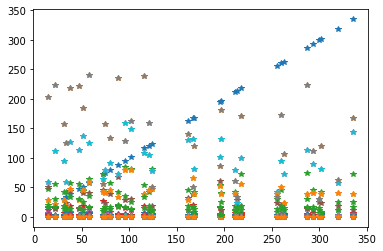

In [278]:
import matplotlib.pyplot as plt
plt.plot(X_train,'*',)
plt.show()


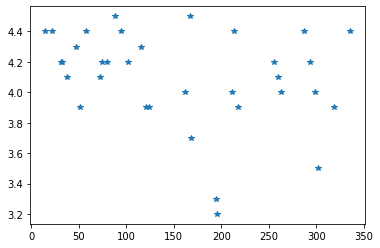

In [279]:
import matplotlib.pyplot as plt
plt.plot(Y_train,'*',)
plt.show()

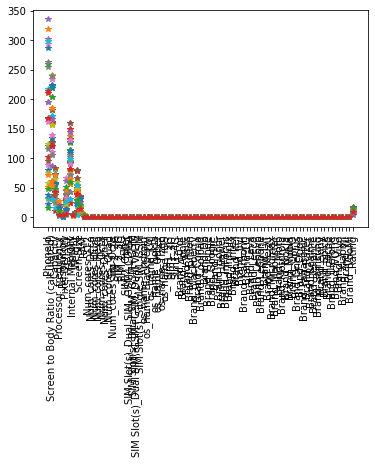

pandas.core.frame.DataFrame

In [280]:
plt.plot(X_train.T,'*')
plt.xticks(rotation='vertical')
plt.show()
type(X_train)

pandas.core.series.Series

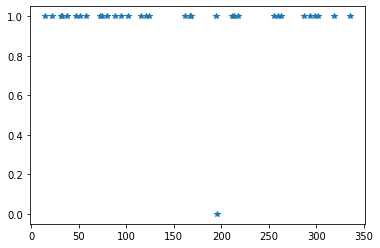

In [281]:
X_binarised_3_train=X_train['Rating'].map(lambda x:0 if x<=4 else 1)
plt.plot(X_binarised_3_train,'*')
type(X_binarised_3_train)

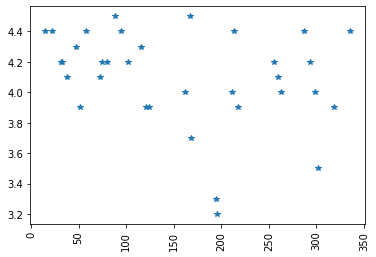

pandas.core.series.Series

In [282]:
plt.plot(Y_train.T,'*')
plt.xticks(rotation='vertical')
plt.show()
type(Y_train)

pandas.core.series.Series

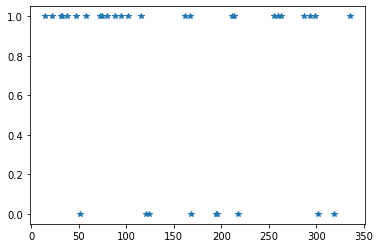

In [283]:
Y_binarised_train=Y_train.map(lambda x:0 if x<4 else 1)
plt.plot(Y_binarised_train,'*')
type(Y_binarised_train)

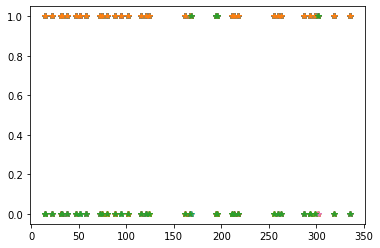

In [284]:
X_binarised_train=X_train.apply(pd.cut,bins=2,labels=[1,0])
type(X_binarised_train)
plt.plot(X_binarised_train,'*')

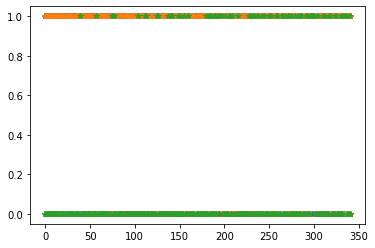

In [285]:
X_binarised_test=X_test.apply(pd.cut,bins=2,labels=[1,0])
type(X_binarised_test)
plt.plot(X_binarised_test,'*')

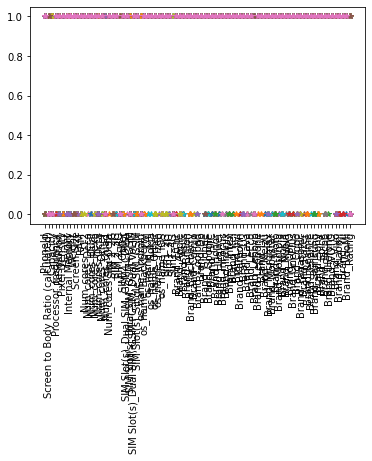

pandas.core.frame.DataFrame

In [286]:
plt.plot(X_binarised_test.T,'*')
plt.xticks(rotation='vertical')
plt.show()
type(X_binarised_test)

pandas.core.series.Series

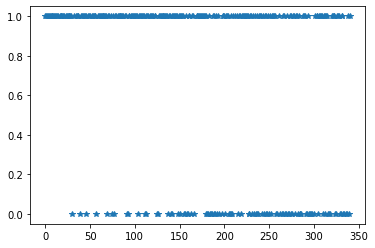

In [287]:
Y_binarised_test=Y_test.map(lambda x:0 if x<4 else 1)
plt.plot(Y_binarised_test,'*')
type(Y_binarised_test)

In [288]:
X_binarised_test=X_binarised_test.values
X_binarised_train=X_binarised_train.values
(type(X_binarised_test))
Y_binarised_test=Y_binarised_test.values
Y_binarised_train=Y_binarised_train.values
(type(Y_binarised_test))


numpy.ndarray

In [289]:
from random import randint
b=3
i=randint(0,X_binarised_train.shape[0])
print('for row',i)
if (np.sum(X_binarised_train[10, :])>=b):
    print("mp neuron inference liked")
else:
    print("mp neuron inference not liked")

if (Y_binarised_train[i]==1):
    print('Ground truth is liked by people')
else:
    print('Ground truth is not liked by people')
    

    

for row 5
mp neuron inference liked
Ground truth is not liked by people


In [290]:
b=3

Y_pred_train=[]
accurate_rows=0
for x,y in zip(X_binarised_train,Y_binarised_train):
    Y_pred=(np.sum(x) >= b)
    Y_pred_train.append(Y_pred)
    accurate_rows += (y==Y_pred)
print(accurate_rows,accurate_rows/X_binarised_train.shape[0])

25 0.7352941176470589


In [291]:
for b in range(X_binarised_train.shape[1]+1):
    Y_pred_train=[]
    accurate_rows=0
    for x,y in zip(X_binarised_train,Y_binarised_train):
        Y_pred=(np.sum(x) >= b)
        Y_pred_train.append(Y_pred)
        accurate_rows += (y==Y_pred)
    print(b,accurate_rows/X_binarised_train.shape[0])

0 0.7352941176470589
1 0.7352941176470589
2 0.7352941176470589
3 0.7352941176470589
4 0.7352941176470589
5 0.7352941176470589
6 0.7352941176470589
7 0.7352941176470589
8 0.7352941176470589
9 0.7352941176470589
10 0.7352941176470589
11 0.7352941176470589
12 0.7352941176470589
13 0.7352941176470589
14 0.7352941176470589
15 0.7352941176470589
16 0.7352941176470589
17 0.7352941176470589
18 0.7352941176470589
19 0.7352941176470589
20 0.7352941176470589
21 0.7352941176470589
22 0.7352941176470589
23 0.7352941176470589
24 0.7352941176470589
25 0.7352941176470589
26 0.7352941176470589
27 0.7352941176470589
28 0.7352941176470589
29 0.7352941176470589
30 0.7352941176470589
31 0.7352941176470589
32 0.7352941176470589
33 0.7352941176470589
34 0.7352941176470589
35 0.7352941176470589
36 0.7352941176470589
37 0.7352941176470589
38 0.7352941176470589
39 0.7352941176470589
40 0.7352941176470589
41 0.7352941176470589
42 0.7352941176470589
43 0.7352941176470589
44 0.7352941176470589
45 0.735294117647058

In [303]:
from sklearn.metrics import accuracy_score
Y_pred_test=[]

b=4

for x in X_binarised_test:
    Y_pred=(np.sum(x) >= b)
    Y_pred_test.append(Y_pred)
accuracy=accuracy_score(Y_pred_test,Y_binarised_test)
print(b,accuracy)

4 0.6938110749185668


## Dummy Solution

In [0]:
class MPneuron:
  def __init(self):
    self.b = None

  def model(self,x):
    return(sum(x)>=self.b)

  def predict(self,X):
    Y = []
    for x in X:
      result = self.model(x)
      Y.append(result)    
    return np.array(Y)

  def fit(self,X,Y):
    accuracy = {}

    for b in range(X.shape[1]+1): #30 columns
      
      self.b = b
      Y_pred = self.predict(X)
      accuracy[b] = accuracy_score(Y_pred , Y)

    best_b = max(accuracy, key = accuracy.get)
    self.b = best_b

    print('Optimal value of b is ',best_b)
    print('Highest value is ',accuracy[best_b])  



In [305]:
mp_neuron = MPneuron()
mp_neuron.fit(X_binarised_train,Y_binarised_train)

Optimal value of b is  0
Highest value is  0.7352941176470589


In [295]:
submission = pd.DataFrame({'PhoneId':test_new['PhoneId'], 'Class':[0]*test_new.shape[0]})
submission = submission[['PhoneId', 'Class']]
submission.head()

,PhoneId,Class
0,3,0
1,11,0
2,13,0
3,16,0
4,19,0


In [0]:
submission.to_csv("submission.csv", index=False)